In [1]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import matplotlib.pyplot as plt

In [2]:
def readDailyProfiles():
    df1= pd.read_excel('LD_Net.xlsx')
    df2=pd.read_excel('PV1_refine1_excel.xlsx')
    print(df1.head())
    RawNetData=df1.iloc[:11630, :]
    Net_data=RawNetData.iloc[-115:-6, 1:].values
    Net_data=Net_data.flatten()
    Max_load=Net_data.max()
    Net_data=Net_data/Max_load
    plt.plot(Net_data)
    plt.show()
    print(df2.head())
    PV_input1=df2.iloc[250:359, 1:25].values
    PV_data=PV_input1.flatten()
    Max_PV=PV_data.max()
    Gamma=100
    print((Max_PV, Max_load, Gamma))
    impact_ratio= Gamma*Max_PV/Max_load
    print('+++++++++++++++++++++++++++++++++++++')
    print(impact_ratio)
    print(PV_data)
    PV_data=(PV_data/PV_data.max())*1
    print(PV_data)
    plt.plot(PV_data)
    plt.show()
    PVDailyProfile=PV_data[:24]
    NetDailyProfile=Net_data[:24]
    return NetDailyProfile, PVDailyProfile

In [3]:
def timeseries_example(output_dir):
    # 1. create test net
    net = simple_test_net()

    # 2. create (random) data source
    n_timesteps = 24
    NetDailyProfile, PVDailyProfile=readDailyProfiles()
    profiles, ds = create_data_source(n_timesteps, NetDailyProfile, PVDailyProfile)
    # 3. create controllers (to control P values of the load and the sgen)
    create_controllers(net, ds)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)

In [4]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b3, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')
    

    return net

In [5]:
def create_data_source(n_timesteps, NetDailyProfile, PVDailyProfile):
    profiles = pd.DataFrame()
#     profiles['load1_p'] = np.random.random(n_timesteps) * 20./20
#     profiles['sgen1_p'] = np.random.random(n_timesteps) * 20./20
    profiles['load1_p'] = NetDailyProfile
    profiles['sgen1_p'] = PVDailyProfile

    ds = DFData(profiles)
    print(profiles)
    plt.plot(profiles['load1_p'].values)
    plt.show()
    plt.plot(profiles['sgen1_p'].values)
    plt.show()
    
    return profiles, ds


In [6]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])
    



In [7]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow



Results can be found in your local temp folder: C:\Users\SHREEK~1\AppData\Local\Temp\time_series_example
     LoadDay  MW01  MW02  MW03  MW04  MW05  MW06  MW07  MW08  MW09  ...  MW15  \
0 1988-01-01  6081  5771  5598  5543  5453  5418  5233  5353  5537  ...  5288   
1 1988-01-02  5213  4929  4728  4723  4768  4962  5037  5546  6117  ...  6060   
2 1988-01-03  5831  5548  5369  5319  5340  5459  5488  5904  6438  ...  6503   
3 1988-01-04  5969  5625  5606  5622  5679  5886  6263  7052  8389  ...  9099   
4 1988-01-05  7089  6899  6888  6866  6914  7096  7386  8049  9207  ...  9455   

   MW16  MW17  MW18  MW19  MW20  MW21  MW22  MW23  MW24  
0  5317  5535  6143  6242  6019  5854  5711  5728  5506  
1  6031  6106  6750  7075  6765  6506  6348  6456  6136  
2  6462  6576  7272  7581  7413  7197  7042  6813  6548  
3  9005  9160  9565  9610  9034  8565  8299  8314  7844  
4  9352  9490  9942  9941  9407  8917  8612  8505  7973  

[5 rows x 25 columns]


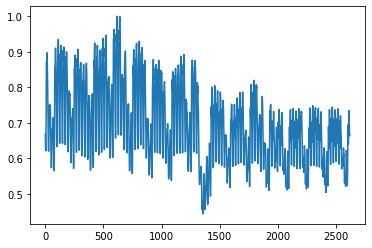

   Unnamed: 0  0:AM  1:AM  2:AM  3:AM  4:AM  5:AM  6:AM  7:AM    8:AM  ...  \
0           0     0     0     0     0     0   0.0   0.0   0.0  28.224  ...   
1           1     0     0     0     0     0   0.0   0.0   0.0  16.416  ...   
2           2     0     0     0     0     0   0.0   0.0   0.0  29.664  ...   
3           3     0     0     0     0     0   0.0   0.0   0.0  23.808  ...   
4           4     0     0     0     0     0   0.0   0.0   0.0  28.992  ...   

      4:PM    5:PM  6:PM  7:PM  8:PM  9:PM  10:PM  11:PM       SUM  \
0   36.960   2.880   0.0   0.0     0     0      0      0  3832.128   
1   55.776   3.168   0.0   0.0     0     0      0      0  2769.504   
2   67.296  12.384   0.0   0.0     0     0      0      0  3750.624   
3   55.296   6.432   0.0   0.0     0     0      0      0  3367.008   
4  111.648   8.352   0.0   0.0     0     0      0      0  1966.368   

   Day development \ time  
0                3.856812  
1                2.787343  
2                3.774783 

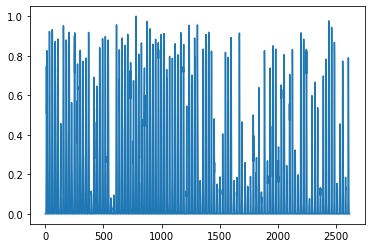

     load1_p   sgen1_p
0   0.668459  0.000000
1   0.644073  0.000000
2   0.630197  0.000000
3   0.621606  0.000000
4   0.620739  0.000000
5   0.628717  0.000000
6   0.660157  0.001118
7   0.716422  0.041713
8   0.794794  0.198837
9   0.840999  0.312346
10  0.862980  0.747484
11  0.871872  0.507940
12  0.848226  0.582756
13  0.883204  0.825878
14  0.897322  0.591926
15  0.896339  0.607247
16  0.895830  0.433460
17  0.868438  0.106464
18  0.839704  0.009953
19  0.830038  0.000000
20  0.817989  0.000000
21  0.785868  0.000000
22  0.748797  0.000000
23  0.730262  0.000000


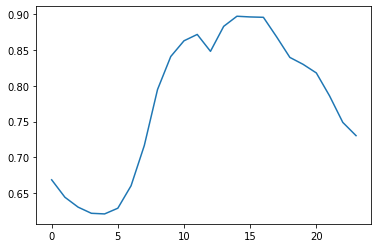

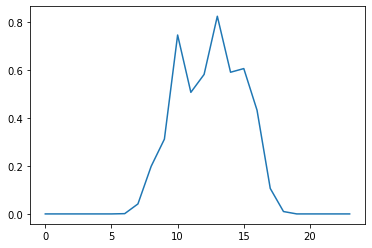

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.31it/s]


In [8]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)



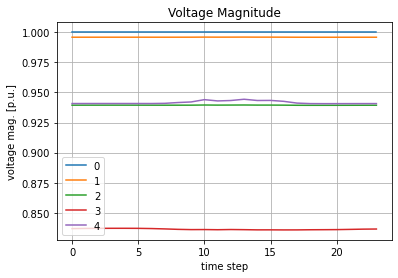

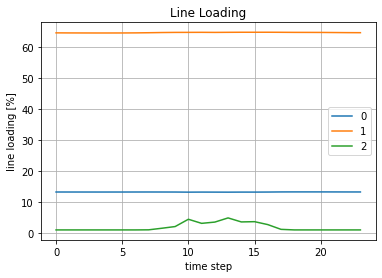

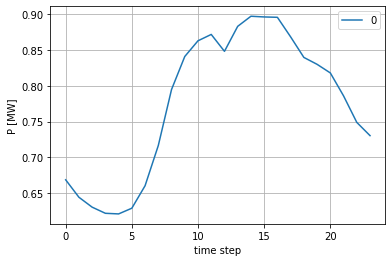

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")        
plt.ylabel("P [MW]")
plt.grid()
plt.show()

